In [1]:
import numpy as np
import xml.etree.ElementTree as ET
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tree = ET.parse('polska')
root = tree.getroot()

In [3]:
Nodes = {}
for node in root.findall(".//{http://sndlib.zib.de/network}node"):
    x = node.find(".//{http://sndlib.zib.de/network}x")
    y = node.find(".//{http://sndlib.zib.de/network}y")
    Nodes[node.get('id')] = [float(x.text), float(y.text)]
Nodes

{'Bialystok': [23.1, 53.1],
 'Bydgoszcz': [17.9, 53.1],
 'Gdansk': [18.6, 54.2],
 'Katowice': [18.8, 50.3],
 'Kolobrzeg': [16.1, 54.2],
 'Krakow': [19.8, 50.0],
 'Lodz': [19.4, 51.7],
 'Poznan': [16.8, 52.4],
 'Rzeszow': [21.9, 50.0],
 'Szczecin': [14.5, 53.4],
 'Warsaw': [21.0, 52.2],
 'Wroclaw': [16.9, 51.1]}

In [4]:
Links = {}
for link in root.findall(".//{http://sndlib.zib.de/network}link"):
    source = link.find(".//{http://sndlib.zib.de/network}source")
    target = link.find(".//{http://sndlib.zib.de/network}target")
    setupCost = link.find(".//{http://sndlib.zib.de/network}setupCost")
    
    longitudeS = Nodes[source.text][0]
    longitudeT = Nodes[target.text][0]
    latitudeS = Nodes[source.text][1]
    latitudeT = Nodes[target.text][1]
    
    #distance1 = math.sqrt((longitudeS - longitudeT)**2 + (latitudeS - latitudeT)**2) * 73
    distance2 = math.acos(math.sin(math.radians(latitudeS))*math.sin(math.radians(latitudeT)) + math.cos(math.radians(latitudeS))*
                          math.cos(math.radians(latitudeT))*math.cos(math.radians(longitudeT - longitudeS)) )* 6371
    Links[link.get('id')] = distance2

{'Link_0_10': 273.8496028378416,
 'Link_0_2': 162.60232837247085,
 'Link_0_5': 320.7405710847887,
 'Link_1_10': 231.811351705841,
 'Link_1_2': 170.38471371325605,
 'Link_1_7': 107.42132232440356,
 'Link_2_9': 137.66780655303617,
 'Link_3_11': 160.6764818757195,
 'Link_3_4': 78.6728876043855,
 'Link_3_6': 161.2340071135855,
 'Link_4_10': 258.5716578236298,
 'Link_4_8': 150.09198393119996,
 'Link_5_10': 173.43699098198317,
 'Link_5_8': 354.5360257175708,
 'Link_6_10': 122.94119213432361,
 'Link_6_11': 185.80862973599406,
 'Link_7_11': 144.71718812896586,
 'Link_7_9': 190.15142627508948}

In [5]:
min(Links.values())

78.6728876043855

In [6]:
def addNodetoPath(node1, node2, input_list):
    if len(input_list) == 2 :
        if node1 in input_list and node1 == input_list[0] :
            #print('pierwszy przypadek')
            second_node = input_list[1]
            input_list[1] = input_list[0]
            input_list[0] = second_node
            input_list.append(node2)
            return input_list
        if node2 in input_list and node2 == input_list[0] :
            #print('drugi przypadek')
            second_node = input_list[1]
            input_list[1] = input_list[0]
            input_list[0] = second_node
            input_list.append(node1)
            return input_list  
    if node1 not in input_list : 
        input_list.append(node1)
    if node2 not in input_list : 
        input_list.append(node2)
        
    return input_list

In [7]:
n = 0
Y_values = []
input_list = []
for demand in root.findall(".//{http://sndlib.zib.de/network}demand"):
    source = demand.find(".//{http://sndlib.zib.de/network}source")
    target = demand.find(".//{http://sndlib.zib.de/network}target")
    demandValue = demand.find(".//{http://sndlib.zib.de/network}demandValue")
    #print(demand.attrib)
    print("Source: " + source.text)
    print("Target: " + target.text)
    print("DemandValue: " + demandValue.text)
    
    admissiblePaths = demand.findall(".//{http://sndlib.zib.de/network}admissiblePath")
    for path in admissiblePaths:
        path_links = path.findall(".//{http://sndlib.zib.de/network}linkId")
        values = 0;
        node_list=[]
        for link_id in path_links:
            values = values + 300./float(Links[link_id.text])
            words = link_id.text.split('_')
            node_list = addNodetoPath(words[1], words[2], node_list)
        input_list.append(node_list.copy()) 
        size = float(len(node_list))
        values= values + 300./min(Links.values())*(11-size)
        values = values + 10./(size-1)
        Y_values.append(values)
        n = n+1
        print(node_list)
        print(values)  
        node_list.clear()
"All paths: {}".format(n)

Source: Gdansk
Target: Bydgoszcz
DemandValue: 195.0
['0', '2', '1']
39.111775527610455
['0', '10', '1']
37.89570976324386
['0', '2', '9', '7', '1']
33.77412898818498
['0', '5', '10', '1']
33.98536367924393
['0', '10', '4', '3', '11', '7', '1']
29.721523571155718
['0', '2', '9', '7', '11', '3', '4', '10', '1']
24.68610440131703
['0', '5', '8', '4', '10', '1']
27.300950612745368
Source: Gdansk
Target: Kolobrzeg
DemandValue: 158.0
['0', '2']
46.16431196677906
['0', '10', '1', '2']
34.17650665740858
['0', '5', '10', '1', '2']
31.09949390674199
['0', '10', '4', '3', '11', '7', '1', '2']
27.430891893891868
['0', '10', '1', '7', '9', '2']
30.005526784649767
['0', '5', '8', '4', '10', '1', '2']
24.91508084024343
['0', '5', '10', '4', '3', '11', '7', '1', '2']
25.008641047987183
Source: Gdansk
Target: Katowice
DemandValue: 174.0
['0', '5', '8', '4', '3']
32.97309041124482
['0', '10', '4', '3']
36.09510728532111
['0', '5', '10', '4', '3']
33.018094534654516
['0', '5', '8', '4', '10', '6', '3']
2

'All paths: 462'

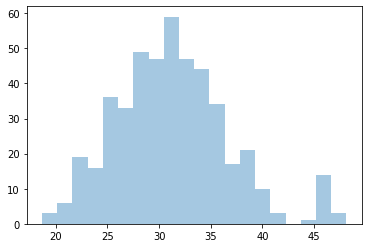

In [8]:
sns.distplot(Y_values,bins=20, kde=False);

In [9]:
"All paths: {}".format(n)

'All paths: 462'

In [10]:
[i for (i,v) in zip(input_list, Y_values) if v>32]

[['0', '2', '1'],
 ['0', '10', '1'],
 ['0', '2', '9', '7', '1'],
 ['0', '5', '10', '1'],
 ['0', '2'],
 ['0', '10', '1', '2'],
 ['0', '5', '8', '4', '3'],
 ['0', '10', '4', '3'],
 ['0', '5', '10', '4', '3'],
 ['0', '10', '6', '3'],
 ['0', '5', '10', '6', '3'],
 ['0', '5', '8', '4'],
 ['0', '10', '4'],
 ['0', '5', '10', '4'],
 ['0', '10', '6', '3', '4'],
 ['0', '5'],
 ['0', '10', '5'],
 ['0', '2', '1', '10', '5'],
 ['0', '10', '6'],
 ['0', '5', '10', '6'],
 ['0', '2', '1', '10', '6'],
 ['0', '10', '4', '3', '6'],
 ['0', '2', '1', '7'],
 ['0', '10', '1', '7'],
 ['0', '2', '9', '7'],
 ['0', '5', '10', '1', '7'],
 ['0', '5', '8'],
 ['0', '10', '4', '8'],
 ['0', '10', '5', '8'],
 ['0', '2', '9'],
 ['0', '2', '1', '7', '9'],
 ['0', '10', '1', '7', '9'],
 ['0', '10'],
 ['0', '2', '1', '10'],
 ['0', '5', '10'],
 ['0', '2', '1', '7', '11'],
 ['0', '2', '9', '7', '11'],
 ['0', '10', '4', '3', '11'],
 ['1', '2'],
 ['1', '7', '9', '2'],
 ['1', '10', '0', '2'],
 ['1', '10', '4', '3'],
 ['1', '10', '

## Some statistics

In [11]:
"Min: {}".format(min(Y_values))

'Min: 18.680154700631682'

In [12]:
"Max: {}".format(max(Y_values))

'Max: 48.13257770689441'

In [13]:
"Mean: {}".format(statistics.mean(Y_values))

'Mean: 31.264953871433754'

## Calculate OSNR values

In [14]:
Y_output = np.array(Y_values)
Y_output.shape

(462,)

In [15]:
#max_val=max(Y_output)
#min_val=min(Y_output)

In [16]:
#Y_output_s = 10 + 35*(Y_output/max_val)

In [17]:
#min(Y_output_s)

In [18]:
#max(Y_output_s)

In [19]:
#sns.distplot(Y_output_s,bins=30, kde=False);

In [20]:
delimit_values=np.quantile(Y_output, [0.25,0.5,0.75])
delimit_values

array([27.69028916, 30.95785005, 34.4318863 ])

In [21]:
Y_output[Y_output<=delimit_values[0]]=0
Y_output[(Y_output>delimit_values[0]) & (Y_output<=delimit_values[1])]=1
Y_output[(Y_output>delimit_values[1]) & (Y_output<=delimit_values[2])]=2
Y_output[Y_output>delimit_values[2]]=3

In [22]:
Y_values

[39.111775527610455,
 37.89570976324386,
 33.77412898818498,
 33.98536367924393,
 29.721523571155718,
 24.68610440131703,
 27.300950612745368,
 46.16431196677906,
 34.17650665740858,
 31.09949390674199,
 27.430891893891868,
 30.005526784649767,
 24.91508084024343,
 25.008641047987183,
 32.97309041124482,
 36.09510728532111,
 33.018094534654516,
 26.1610444651115,
 30.939635729111004,
 35.422470282276656,
 32.345457531610066,
 33.806423744578154,
 37.76177395198777,
 33.85142786798785,
 31.439635729111004,
 34.58913694894332,
 31.84545753161006,
 27.768655856352193,
 45.25465530393023,
 38.33128879246759,
 32.00915056959082,
 30.48020905930236,
 28.338170696832012,
 25.873293587426318,
 25.824737503092262,
 30.520482297353006,
 39.041745062835126,
 35.13139897883521,
 28.44698591233664,
 27.99491179763257,
 32.71960683995836,
 33.309165838095964,
 36.424592731378674,
 35.20852696701208,
 35.62797845108343,
 26.68180623974882,
 32.13151421634548,
 31.075373034054163,
 28.97350647504627,


In [23]:
X_input = np.full((462,11), -1)
X_input.shape

(462, 11)

In [24]:
n = 0
for path in input_list:
    for i in range(len(path)):
        X_input[n][i] = path[i]
    n =n+1

In [25]:
X_input

array([[ 0,  2,  1, ..., -1, -1, -1],
       [ 0, 10,  1, ..., -1, -1, -1],
       [ 0,  2,  9, ..., -1, -1, -1],
       ...,
       [10,  1,  7, ..., -1, -1, -1],
       [10,  6,  3, ..., -1, -1, -1],
       [10,  4,  8, ..., 11, -1, -1]])

# random forest

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import plot

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X_input,Y_output, test_size=0.25)

In [28]:
n_B=int(math.sqrt(len(X_train)))
n_B

18

In [29]:
rf = RandomForestRegressor(n_estimators = n_B, max_samples=n_B, max_features="auto", random_state = 42)
rf.fit(X_train, Y_train);
predictions = rf.predict(X_test)
predictions=np.round(predictions,0)

In [30]:
error= predictions==Y_test
np.sum(error)/len(error)

0.7068965517241379

## Accuracy for different number of trees in random forest 

In [31]:
B_values=[]
acc_values=[]

In [32]:
for n in range(int(math.sqrt(n_B)),20*n_B, 2):
    rf = RandomForestRegressor(n_estimators =n ,max_features="auto", random_state = 42)
    rf.fit(X_train, Y_train);
    predictions = rf.predict(X_test)
    predictions=np.round(predictions,0)
    acc_values.append(np.sum(predictions==Y_test)/len(Y_test))
    B_values.append(n)
    

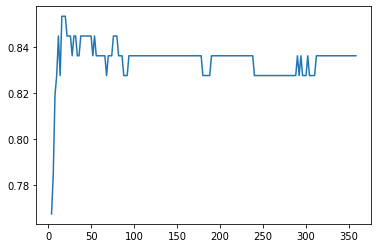

In [33]:
plot(B_values,acc_values)

In [36]:
best_treeN=[x for (x,y) in zip(B_values,acc_values) if y==max(acc_values)][0]
best_treeN

16

## Accuracy for different depths of trees

In [37]:
Depth_values=[]
acc_values=[]

In [38]:
for n in range(1,12):
    rf = RandomForestRegressor(n_estimators =best_treeN ,max_depth=n,max_samples=n,max_features="auto", random_state = 42)
    rf.fit(X_train, Y_train);
    predictions = rf.predict(X_test)
    predictions=np.round(predictions,0)
    acc_values.append(np.sum(predictions==Y_test)/len(Y_test))
    Depth_values.append(n)

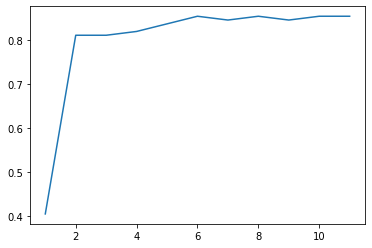

In [39]:
plot(Depth_values,acc_values)

In [40]:
best_depth=[x for (x,y) in zip(Depth_values,acc_values) if y==max(acc_values)][0]
best_depth

6

In [41]:
max(acc_values)

0.853448275862069

## Accuracy for different sizes of samples to draw from X to train each base estimator

In [53]:
B1_values=[]
acc_values=[]

In [54]:
for n in range(int(math.sqrt(n_B)),len(X_train)):
    rf = RandomForestRegressor(n_estimators =best_treeN,max_depth=best_depth,max_samples=n, bootstrap=True,max_features="auto", random_state = 42)
    rf.fit(X_train, Y_train);
    predictions = rf.predict(X_test)
    predictions=np.round(predictions,0)
    acc_values.append(np.sum(predictions==Y_test)/len(Y_test))
    B1_values.append(n)
    

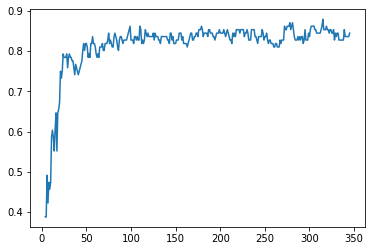

In [55]:
plot(B1_values,acc_values)

In [56]:
best_bootstrap=[x for (x,y) in zip(B1_values,acc_values) if y==max(acc_values)][0]
best_bootstrap

315

In [59]:
acc_values[315]

0.8620689655172413

In [63]:
acc_values[106]

0.8620689655172413

In [64]:
best_bootstrap=acc_values[106]